# Basketball Trajectory Prediction Model

## Retrieve Files

In [ ]:
!rm -rf BasketballTrajectoryPrediction

In [ ]:
!git clone https://github.com/Charlychee/BasketballTrajectoryPrediction

import sys
sys.path.append('BasketballTrajectoryPrediction')

Cloning into 'BasketballTrajectoryPrediction'...
remote: Enumerating objects: 31, done.
remote: Counting objects: 100% (31/31), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 31 (delta 14), reused 25 (delta 8), pack-reused 0
Unpacking objects: 100% (31/31), 7.21 KiB | 923.00 KiB/s, done.


In [ ]:
# Download Dataset
!gdown --folder https://drive.google.com/drive/folders/1fW8lRaee7scBacO9XJJeD3TAOi1QCwhd?usp=sharing

Retrieving folder list
Retrieving folder 1DUct1haP12hungw7H1R4y6bx7A6p1AN0 test
Processing file 1QLF0L0gV3N_ret4PoWY7IFm3ew-8cKxR 0021500046.json
Retrieving folder 1VYG8siqmDAamys8Dp5wUDdQ348OjvxK8 train
Processing file 1gEwQhPBjM8AP6NLVUShdsRwBg7J4dscL 0021500001.json
Processing file 1tXEomqHi0b3gDNHmLfv_WmxNrsUOwn4t 0021500002.json
Processing file 1HpsddImMBpWnCBAvB8e3NespWqdGnSt4 0021500003.json
Processing file 1adn3sYF9s-kSU1Grwo-Z1KWM8hbnCK2A 0021500004.json
Processing file 1ZHar2Q8bSNUrv0LTrVDLqThwL8V8Q6A7 0021500005.json
Processing file 1U_HgW2uLIfPYJmsJhwmc7qOmOjII3JiD 0021500007.json
Processing file 1WeggqJefEz9jIvAt8_GKWoooMMZCeQUc 0021500009.json
Processing file 1fTc_sXazoST0En0zs9Rf6dhvgwbnmjPp 0021500010.json
Retrieving folder 1-wxmYISWfl2A3OQ9J81g73QPu82W5FHH validation
Processing file 1Qglz1txOuXFNiXh05Ih3gFa8jdUTiNLe 0021500041.json
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.goo

In [ ]:
# Download Trained Models
!gdown --folder https://drive.google.com/drive/folders/12yvNsd5_hnr6dOtarvfmViUp2wxwsq3C?usp=drive_link

Retrieving folder list
Processing file 1nEsEZgGk63ZM0ujWCN-uABKZMEfYGme0 ballerModel.pt
Processing file 1NdLVVUE8JRxVs__0NTh1EqZUMVAkUIv_ ballerModel2.pt
Processing file 17EXsG6IH0fgjHo6jmhbRFFfsjJHWzD1Z ballerModel3_2.pt
Processing file 1yy0Vl7O8gphu00jL1DJJwt08uC48Crzm ballerModel3_3.pt
Processing file 1l14JhzTiq2CGZu76pJu294_UwkF5CCDa ballerModel3_4.pt
Processing file 1guZXIDSd4QvXGLFZdPpU72BHuTU-W-_Y ballerModel3.pt
Processing file 104xJhM3o2CqnDVaggLqTTd3MKu885l_0 ballerModel4_3-12_epochs.pt
Processing file 1ypciLTYXpZ4hrDoSUG-GPIN12g8CZzHR ballerModel4_4-50_epochs.pt
Processing file 1JEPO8fxB3RGWiPcR-0RyacfrdLjEOppO macro5050.pt
Retrieving folder list completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1nEsEZgGk63ZM0ujWCN-uABKZMEfYGme0
To: /content/Models/ballerModel.pt
100% 99.7M/99.7M [00:00<00:00, 173MB/s]
Downloading...
From: https://drive.google.com/uc?id=1NdLVVUE8JRxVs__0NTh1EqZUMVAkUIv_
To: /cont

## Creating Datasets - Extracting Sequence Data

In [ ]:
import ballJson2Arr

from glob import glob
folders = glob('Data/*')

micro_in_seq, micro_out_seq = 25, 15
macro_in_seq, macro_out_seq = 50, 50

In [ ]:
for folder in folders:
  for file in glob(f'{folder}/*.json'):
    ballJson2Arr.file2Arr(file, micro_in_seq, micro_out_seq)

In [ ]:
for folder in folders:
  for file in glob(f'{folder}/*.json'):
    ballJson2Arr.file2Arr(file, macro_in_seq, macro_out_seq)

# Experiment 1 - Micro Interaction

In [ ]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

## Creating Datasets - Setting up Dataset Objects

In [ ]:
from ballerDataset import BallerDataset
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_dataset_micro = BallerDataset('./Data/train', micro_in_seq, micro_out_seq, includePlayerOut=True)
validation_dataset_micro = BallerDataset('./Data/validation', micro_in_seq, micro_out_seq, includePlayerOut=True)
test_dataset_micro = BallerDataset('./Data/test', micro_in_seq, micro_out_seq, includePlayerOut=True)

train_dataloader_micro = DataLoader(train_dataset_micro, batch_size=BATCH_SIZE)
validation_dataloader_micro = DataLoader(validation_dataset_micro, batch_size=BATCH_SIZE)
test_dataloader_micro = DataLoader(test_dataset_micro, batch_size=BATCH_SIZE)

## Setup Model

In [ ]:
from transformerModel import BallerModel
from torch.optim.lr_scheduler import ReduceLROnPlateau

PLAYER_BALL_ENCODING_SIZE = 8   #this number *2 must be divisible by n_heads
DROPOUT = 0.5

LR = 1e-3
EPOCHS = 3
SCHEDULER_PATIENCE = 10

micro_model = BallerModel(player_ball_encoding_size=PLAYER_BALL_ENCODING_SIZE,
                          ball_output_dim=3,
                          dropout=DROPOUT)

micro_model = micro_model.double()
micro_model = micro_model.to(device)

loss_func = torch.nn.MSELoss()
optim = torch.optim.Adam(micro_model.parameters(), lr = LR)
scheduler = ReduceLROnPlateau(optim, mode='min', patience=SCHEDULER_PATIENCE, verbose=True)

In [ ]:
tgt_mask = BallerModel.generate_square_subsequent_mask(
    dim1=micro_out_seq,
    dim2=micro_out_seq
    )
src_mask = BallerModel.generate_square_subsequent_mask(
    dim1=micro_out_seq,
    dim2=micro_in_seq
    )
tgt_mask = tgt_mask.to(device)
src_mask = src_mask.to(device)

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]

import engineMicro

## Train Model

################
#Begin training#
################
[Epoch: 0, Batch:   10] loss: 0.282
[Epoch: 0, Batch:   20] loss: 0.279
[Epoch: 0, Batch:   30] loss: 0.267
[Epoch: 0, Batch:   40] loss: 0.282
[Epoch: 0, Batch:   50] loss: 0.267
[Epoch: 0, Batch:   60] loss: 0.262
[Epoch: 0, Batch:   70] loss: 0.269
[Epoch: 0, Batch:   80] loss: 0.265
[Epoch: 0, Batch:   90] loss: 0.262
[Epoch: 0, Batch:  100] loss: 0.255
[Epoch: 0, Batch:  110] loss: 0.265
[Epoch: 0, Batch:  120] loss: 0.267
[Epoch: 0, Batch:  130] loss: 0.257
[Epoch: 0, Batch:  140] loss: 0.256
[Epoch: 0, Batch:  150] loss: 0.246
[Epoch: 0, Batch:  160] loss: 0.236
[Epoch: 0, Batch:  170] loss: 0.249
[Epoch: 0, Batch:  180] loss: 0.243
[Epoch: 0, Batch:  190] loss: 0.239
[Epoch: 0, Batch:  200] loss: 0.248
[Epoch: 0, Batch:  210] loss: 0.231
[Epoch: 0, Batch:  220] loss: 0.232
[Epoch: 0, Batch:  230] loss: 0.245
[Epoch: 0, Batch:  240] loss: 0.231
[Epoch: 0, Batch:  250] loss: 0.222
[Epoch: 0, Batch:  260] loss: 0.239
Epoch:0  Trai

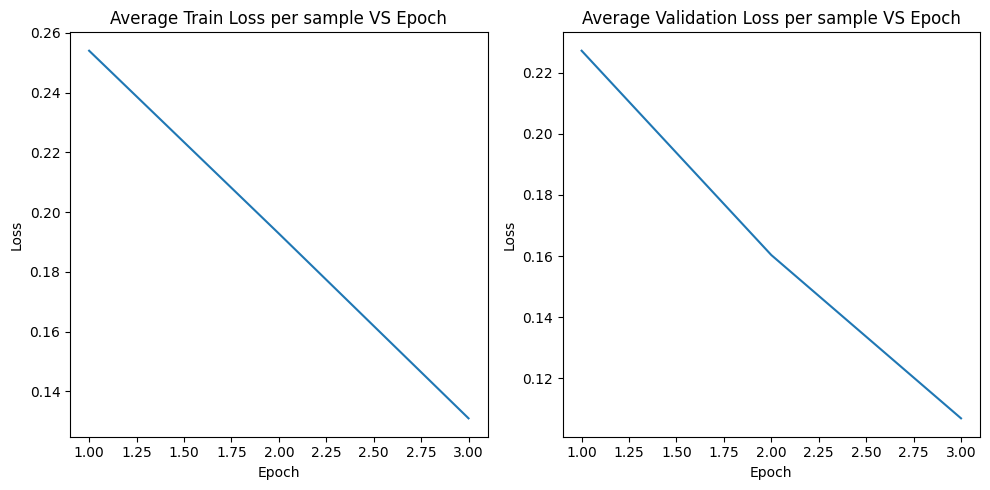

In [ ]:
micro_model, train_losses, val_losses = engineMicro.train(model = micro_model,
      loss_func=loss_func,
      optim=optim,
      scheduler=scheduler,
      dataloaders=(train_dataloader_micro,validation_dataloader_micro),
      epochs=EPOCHS,
      device=device,
      src_mask=src_mask,
      tgt_mask=tgt_mask,
      verbose=True
)

### Load Model from Previous Run

In [ ]:
micro_model.load_state_dict(torch.load('Models/ballerModel4_4-50_epochs.pt', map_location=device)['model_state_dict'])

<All keys matched successfully>

## Evaluate Model

In [ ]:
bestVal = float('Inf')
besty = None
bestout = None
bestplayer = None

test_losses = []

micro_model.eval()
with torch.no_grad():
    for i, (X,y, player) in enumerate(test_dataloader_micro):
        X = X.to(device)
        y = y.to(device)
        player = player.to(device)
        out = engineMicro.run_inference(
            model=micro_model,
            src=X,
            forecast_window=micro_out_seq,
            batch_size=X.shape[0],
            device=device
        )

        loss = torch.sqrt(torch.nn.MSELoss(reduction='none')(out,y))
        test_losses.append(torch.sqrt(loss_func(out,y)))
        batchVal = loss.mean(axis=1).mean(axis=1).min()
        if batchVal < bestVal:
            bestI = loss.mean(axis=1).mean(axis=1).argmin()
            bestX = X[bestI]
            besty = y[bestI]
            bestout = out[bestI]
            bestplayer = player[bestI]
            bestVal = batchVal

print(f'The mean test loss is: {torch.tensor(test_losses).mean().item()}')

The mean test loss is: 3.2180526535919953


In [ ]:
def plotSequenceMicro(X, y, out, num, save=False):
    import os
    import imageio
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.plot(X[:,0,0].tolist(), X[:,0,1].tolist(), X[:,0,2].tolist(), marker='o', color='blue')
    ax.scatter(X[0,0,0].tolist(), X[0,0,1].tolist(), X[0,0,2].tolist(), marker='D', s=50)

    # Truth
    ax.plot([X[-1,0,0].tolist()] + y[:,0].tolist(), [X[-1,0,1].tolist()] + y[:,1].tolist(), [X[-1,0,2].tolist()] + y[:,2].tolist()
            , color='green', linestyle='dashed', marker='.')

    # Pred
    ax.plot([X[-1,0,0].tolist()] + out[:,0].tolist(), [X[-1,0,1].tolist()] + out[:,1].tolist(), [X[-1,0,2].tolist()] + out[:,2].tolist()
            , color='red', linestyle='dashed', marker='.')


    if save:
        path = f'vizOut/{num}'
        if not os.path.exists('vizOut'): os.mkdir('vizOut')
        if not os.path.exists(path): os.mkdir(path)

        for i in range(0, 360, 6):
            ax.view_init(azim=i, elev=30)
            plt.savefig(f'{path}/out_{i}.png')

        frames = []
        for i in range(0, 360, 6):
            image = imageio.v2.imread(f'{path}/out_{i}.png')
            frames.append(image)

        imageio.mimsave(f'{path}.gif', # output gif
                    frames,          # array of input frames
                       )
    else:
        ax.view_init(azim=45, elev=30)
        plt.show()

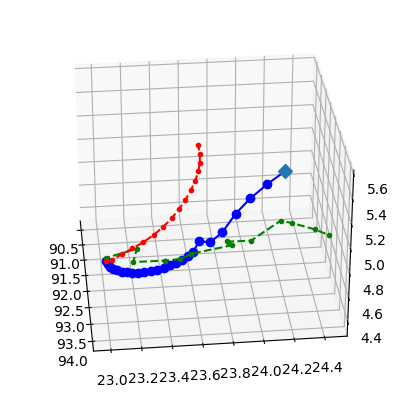

In [ ]:
plotSequenceMicro(bestX, besty, bestout, 998, save=True)

In [ ]:
import matplotlib.animation as animation
def simulateSequenceMicro(X, y, out, player, fname='simulation.gif'):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    seq = torch.concat((X, player), dim=0)

    smallest = torch.concat((seq.min(axis=1)[0], out), dim=0).min(axis=0)[0]
    largest = torch.concat((seq.max(axis=1)[0], out), dim=0).max(axis=0)[0]

    e = 5
    diff = (largest - smallest).max() + e*2
    mid = (largest + smallest)/2

    ze = 1

    ax.set_xlim(mid[0].item() - diff/2, mid[0].item() + diff/2)
    ax.set_ylim(mid[1].item() - diff/2, mid[1].item() + diff/2)
    ax.set_zlim(0, max(largest[2].item(),6)+ze)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    scatters = []

    for i in range(1,11):
        scat = ax.scatter(X[0,i,0], X[0,i,1], X[0,i,2], marker='x', color='purple' if i < 6 else 'orange')
        scatters.append(scat)

    input_ball = ax.plot([],[],[], marker='.', linestyle='-', color='blue')[0]
    output_ball = ax.plot([],[],[], marker='.', linestyle='-', color='red')[0]
    output_true_ball = ax.plot([],[],[], marker='.', linestyle='-', color='green')[0]

    def animate(num, scatters, input_ball, output_ball, output_true_ball):
        if num < X.shape[0]:
            for i, scat in enumerate(scatters):
                i = i+1
                scat._offsets3d = ([X[num,i,0].tolist()], [X[num,i,1].tolist()], [6])
            input_ball.set_data(X[:num,0,0].tolist(), X[:num,0,1].tolist())
            input_ball.set_3d_properties(X[:num,0,2].tolist())
        else:
            num -= X.shape[0]
            for i, scat in enumerate(scatters):
                i = i+1
                scat._offsets3d = ([player[num,i,0].tolist()], [player[num,i,1].tolist()], [6])

            output_ball.set_data(out[:num,0].tolist(), out[:num,1].tolist())
            output_ball.set_3d_properties(out[:num,2].tolist())
            output_true_ball.set_data(y[:num,0].tolist(), out[:num,1].tolist())
            output_true_ball.set_3d_properties(y[:num,2].tolist())

        return

    ani = animation.FuncAnimation(fig, animate,
                                        frames=X.shape[0]+y.shape[0], fargs=[scatters, input_ball, output_ball, output_true_ball], interval=50)

    writer = animation.PillowWriter(fps=5,
                                    metadata=dict(artist='Me'),
                                    bitrate=1800)
    ani.save(fname, writer=writer)
    return

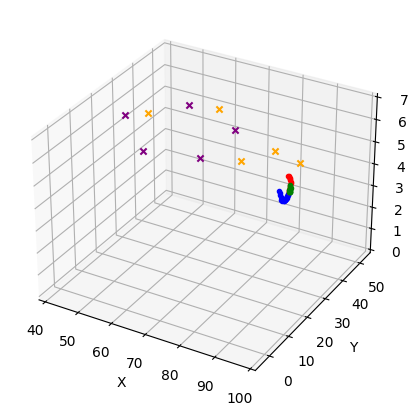

In [ ]:
simulateSequenceMicro(bestX.cpu(), besty.cpu(), bestout.cpu(), bestplayer.cpu(), 'vizOut/MicroSimulation.gif')

# Experiment 2 - Macro Interaction

## Creating Datasets - Setting Up Dataset Objects

In [ ]:
train_dataset_macro = BallerDataset('./Data/train', macro_in_seq, macro_out_seq, includePlayerOut=True)
validation_dataset_macro = BallerDataset('./Data/validation', macro_in_seq, macro_out_seq, includePlayerOut=True)
test_dataset_macro = BallerDataset('./Data/test', macro_in_seq, macro_out_seq, includePlayerOut=True)

train_dataloader_macro = DataLoader(train_dataset_macro, batch_size=BATCH_SIZE)
validation_dataloader_macro = DataLoader(validation_dataset_macro, batch_size=BATCH_SIZE)
test_dataloader_macro = DataLoader(test_dataset_macro, batch_size=BATCH_SIZE)

## Setup Model

In [ ]:
macro_model = BallerModel(player_ball_encoding_size=PLAYER_BALL_ENCODING_SIZE,
                          ball_output_dim=2,
                          dropout=DROPOUT)

macro_model = macro_model.double()
macro_model = macro_model.to(device)

loss_func = torch.nn.MSELoss()
optim = torch.optim.Adam(macro_model.parameters(), lr = LR)
scheduler = ReduceLROnPlateau(optim, mode='min', patience=SCHEDULER_PATIENCE, verbose=True)

In [ ]:
tgt_mask = BallerModel.generate_square_subsequent_mask(
    dim1=macro_out_seq,
    dim2=macro_out_seq
    )
src_mask = BallerModel.generate_square_subsequent_mask(
    dim1=macro_out_seq,
    dim2=macro_in_seq
    )
tgt_mask = tgt_mask.to(device)
src_mask = src_mask.to(device)

In [ ]:
import engineMacro

## Train Model

################
#Begin training#
################
[Epoch: 0, Batch:   10] loss: 0.340
[Epoch: 0, Batch:   20] loss: 0.334
[Epoch: 0, Batch:   30] loss: 0.326
[Epoch: 0, Batch:   40] loss: 0.327
[Epoch: 0, Batch:   50] loss: 0.325
[Epoch: 0, Batch:   60] loss: 0.329
[Epoch: 0, Batch:   70] loss: 0.312
[Epoch: 0, Batch:   80] loss: 0.315
[Epoch: 0, Batch:   90] loss: 0.318
[Epoch: 0, Batch:  100] loss: 0.310
[Epoch: 0, Batch:  110] loss: 0.316
Epoch:0  Train Loss:0.32457  Val Loss:0.32424, Total Time:97.76305341720581, Epoch Time:97.76305341720581
[Epoch: 1, Batch:   10] loss: 0.317
[Epoch: 1, Batch:   20] loss: 0.312
[Epoch: 1, Batch:   30] loss: 0.303
[Epoch: 1, Batch:   40] loss: 0.303
[Epoch: 1, Batch:   50] loss: 0.301
[Epoch: 1, Batch:   60] loss: 0.303
[Epoch: 1, Batch:   70] loss: 0.286
[Epoch: 1, Batch:   80] loss: 0.288
[Epoch: 1, Batch:   90] loss: 0.291
[Epoch: 1, Batch:  100] loss: 0.281
[Epoch: 1, Batch:  110] loss: 0.287
Epoch:1  Train Loss:0.29862  Val Loss:0.29333, Tota

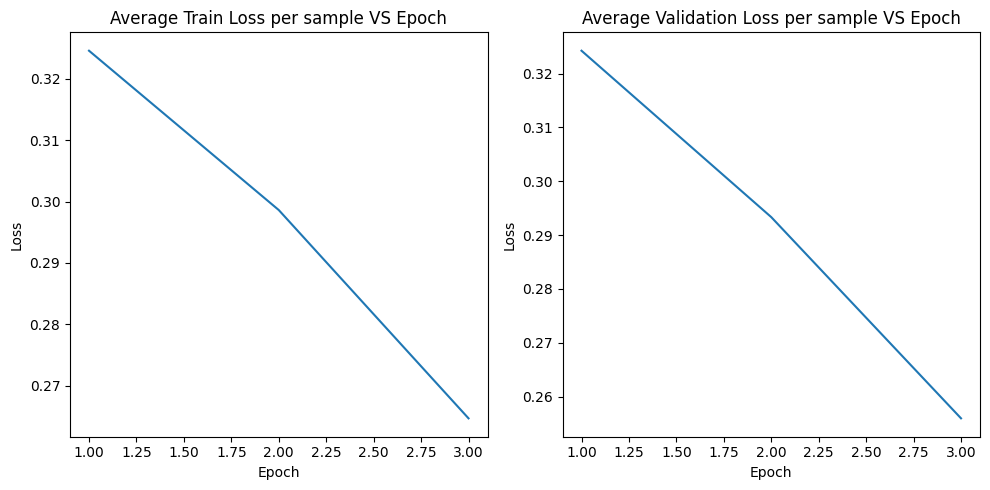

In [ ]:
macro_model, train_losses, val_losses = engineMacro.train(model = macro_model,
      loss_func=loss_func,
      optim=optim,
      scheduler=scheduler,
      dataloaders=(train_dataloader_macro,validation_dataloader_macro),
      epochs=EPOCHS,
      device=device,
      src_mask=src_mask,
      tgt_mask=tgt_mask,
      verbose=True
)

### Load Model from Previous Run

In [ ]:
macro_model.load_state_dict(torch.load('Models/macro5050.pt', map_location=device))

<All keys matched successfully>

## Evaluate Model

In [ ]:
bestVal = float('Inf')
besty = None
bestout = None
bestplayer = None

test_losses = []

macro_model.eval()
with torch.no_grad():
    for i, (X,y, player) in enumerate(test_dataloader_macro):
        X = X.to(device)
        y = y.to(device)
        y = y[:,:,:-1]

        player = player.to(device)
        out = engineMacro.run_inference(
            model=macro_model,
            src=X,
            forecast_window=macro_out_seq,
            batch_size=X.shape[0],
            device=device
        )

        loss = torch.sqrt(torch.nn.MSELoss(reduction='none')(out,y))
        test_losses.append(torch.sqrt(loss_func(out,y)))
        batchVal = loss.mean(axis=1).mean(axis=1).min()
        if batchVal < bestVal:
            bestI = loss.mean(axis=1).mean(axis=1).argmin()
            bestX = X[bestI]
            besty = y[bestI]
            bestout = out[bestI]
            bestplayer = player[bestI]
            bestVal = batchVal

print(f'The mean test loss is: {torch.tensor(test_losses).mean().item()}')

The mean test loss is: 14.473619973983826


In [ ]:
def plotSequenceMacro(X, y, out):
    import os
    import imageio
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(X[:,0,0].tolist(), X[:,0,1].tolist(),  marker='o', color='blue')
    ax.scatter(X[0,0,0].tolist(), X[0,0,1].tolist(), marker='D', s=50)

    # Truth
    ax.plot([X[-1,0,0].tolist()] + y[:,0].tolist(), [X[-1,0,1].tolist()] + y[:,1].tolist(),
             color='green', linestyle='dashed', marker='.')

    # Pred
    ax.plot([X[-1,0,0].tolist()] + out[:,0].tolist(), [X[-1,0,1].tolist()] + out[:,1].tolist(),
             color='red', linestyle='dashed', marker='.')
    plt.show()


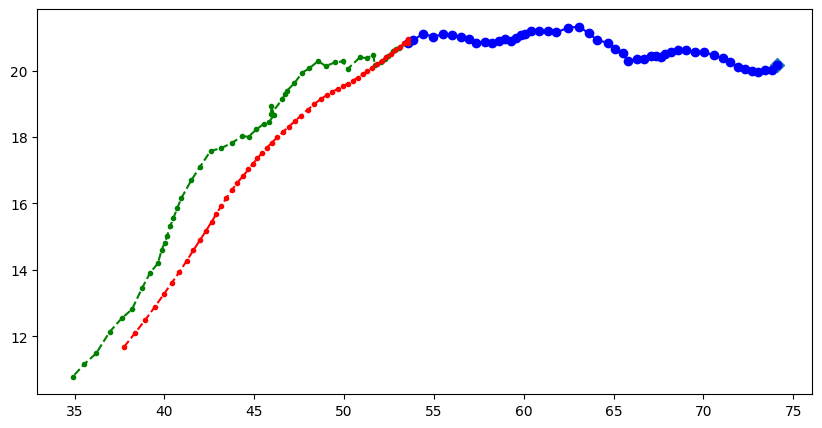

In [ ]:
plotSequenceMacro(bestX, besty, bestout)

In [ ]:
import matplotlib.animation as animation
def simulateSequenceMacro(X, y, out, player, fname='simulation.gif'):
    X = X.cpu()
    y = y.cpu()
    out = out.cpu()
    player = player.cpu()

    fig = plt.figure()
    ax = fig.add_subplot()

    seq = torch.cat((X, player), dim=0)
    seq = seq[:,:,:-1] #only xy

    smallest = torch.cat((seq.min(axis=1)[0], out), dim=0).min(axis=0)[0]
    largest = torch.cat((seq.max(axis=1)[0], out), dim=0).max(axis=0)[0]

    e = 5
    diff = (largest - smallest).max() + e*2
    diff = diff.cpu()
    mid = (largest + smallest)/2

    ze = 1

    ax.set_xlim(mid[0].item() - diff/2, mid[0].item() + diff/2)
    ax.set_ylim(mid[1].item() - diff/2, mid[1].item() + diff/2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')


    scatters = []

    for i in range(1,11):
        scat = ax.scatter(X[0,i,0], X[0,i,1],  marker='x', color='purple' if i < 6 else 'orange')
        scatters.append(scat)

    input_ball = ax.plot([],[], marker='.', linestyle='-', color='blue')[0]
    output_ball = ax.plot([],[], marker='.', linestyle='-', color='red')[0]
    output_true_ball = ax.plot([],[], marker='.', linestyle='-', color='green')[0]

    def animate(num, scatters, input_ball, output_ball, output_true_ball):
        if num < X.shape[0]:
            for i, scat in enumerate(scatters):
                i = i+1
                scat.set_offsets((X[num,i,0].tolist(), X[num,i,1].tolist()))
            input_ball.set_data(X[:num,0,0].tolist(), X[:num,0,1].tolist())
        else:
            num -= X.shape[0]
            for i, scat in enumerate(scatters):
                i = i+1
                scat.set_offsets((player[num,i,0].tolist(), player[num,i,1].tolist()))

            output_ball.set_data(out[:num,0].tolist(), out[:num,1].tolist())
            output_true_ball.set_data(y[:num,0].tolist(), out[:num,1].tolist())

        return

    ani = animation.FuncAnimation(fig, animate,
                                        frames=X.shape[0]+y.shape[0], fargs=[scatters, input_ball, output_ball, output_true_ball], interval=50)

    writer = animation.PillowWriter(fps=15,
                                    metadata=dict(artist='Me'),
                                    bitrate=1800)
    ani.save(fname, writer=writer)
    return


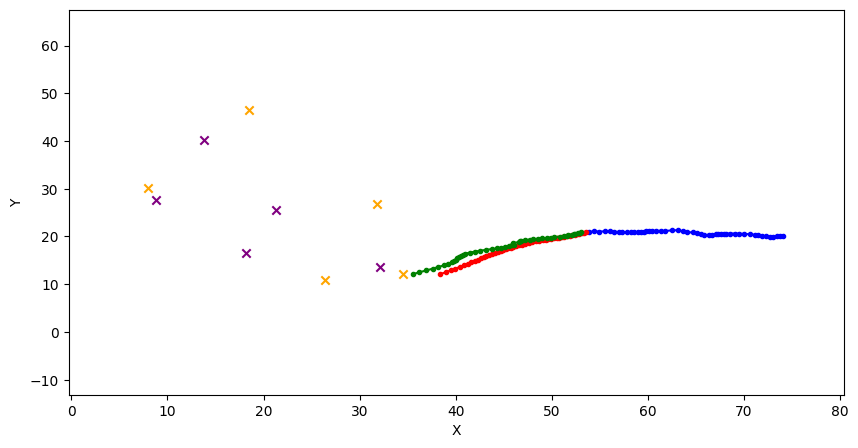

In [ ]:
simulateSequenceMacro(bestX, besty, bestout, bestplayer, fname='vizOut/MacroSimulation.gif')